# DSE315 Project
## Approch 1

## Fine-Tuning SwinV2 for Deepfake Classification

This notebook provides a step-by-step guide to training a **SwinV2 Small** model to classify images as either 'real' or 'fake' (AI-generated).

The process covers:
1.  **Setup**: Installing necessary libraries.
2.  **Exploratory Data Analysis (EDA)**: Understanding the dataset distribution.
3.  **Data Preparation**: Loading the metadata and splitting the dataset.
4.  **Dataset Creation**: Using a custom PyTorch `Dataset` for efficient data loading with augmentations.
5.  **Model Configuration**: Loading the pre-trained SwinV2 model and adapting it for our binary classification task.
6.  **Training**: Fine-tuning the model using the Hugging Face `Trainer` API.
7.  **Inference**: Using the trained model to make predictions on new images.

### Step 1: Install Libraries


In [ ]:
!pip install -q transformers datasets evaluate accelerate pandas scikit-learn matplotlib seaborn

### Step 2: Prepare the Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

# Setting the base directory of data here becasuse we will be resuing this
base_dir = 'celeb_df_preprocessed/Celeb-DF Preprocessed'

data = []

# Load the training data
train_fake_path = os.path.join(base_dir, 'train', 'fake')
train_real_path = os.path.join(base_dir, 'train', 'real')

fake_images = glob.glob(os.path.join(train_fake_path, '*.jpg'))
real_images = glob.glob(os.path.join(train_real_path, '*.jpg'))
fake_images = fake_images[:10901]  # Take only first 10,901 fake images to balance the data distribution.
#create metadata by assigning labels
for img_path in fake_images:
    data.append({
        'image_path': img_path,
        'label': 1,
        'status': 'fake'
    })
for img_path in real_images:
    data.append({
        'image_path': img_path,
        'label': 0,
        'status': 'real'
    })

# Create DataFrame from the metadata
df = pd.DataFrame(data)
print(f"First few rows:")
print(df.head())

First few rows:
                                          image_path  label status
0  celeb_df_preprocessed/Celeb-DF Preprocessed\tr...      1   fake
1  celeb_df_preprocessed/Celeb-DF Preprocessed\tr...      1   fake
2  celeb_df_preprocessed/Celeb-DF Preprocessed\tr...      1   fake
3  celeb_df_preprocessed/Celeb-DF Preprocessed\tr...      1   fake
4  celeb_df_preprocessed/Celeb-DF Preprocessed\tr...      1   fake


In [3]:
# Load the  validation data
val_fake_path = os.path.join(base_dir, 'val', 'fake')
val_real_path = os.path.join(base_dir, 'val', 'real')

val_data = []

val_fake_images = glob.glob(os.path.join(val_fake_path, '*.jpg'))
val_real_images = glob.glob(os.path.join(val_real_path, '*.jpg'))

for img_path in val_fake_images[:3114]:
    val_data.append({
        'image_path': img_path,
        'label': 1,
        'status': 'fake'
    })
for img_path in val_real_images:
    val_data.append({
        'image_path': img_path,
        'label': 0,
        'status': 'real'
    })

val_df = pd.DataFrame(val_data)

print(f"Training set size: {len(df)}")
print(f"Validation set size: {len(val_df)}")

Training set size: 21802
Validation set size: 6228


### Step 3: Exploratory Data Analysis (EDA)

C:\Users\komal\AppData\Local\Temp\ipykernel_25544\953561157.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='status', palette='Set2')  # assigned to ax for adding counts in the plot


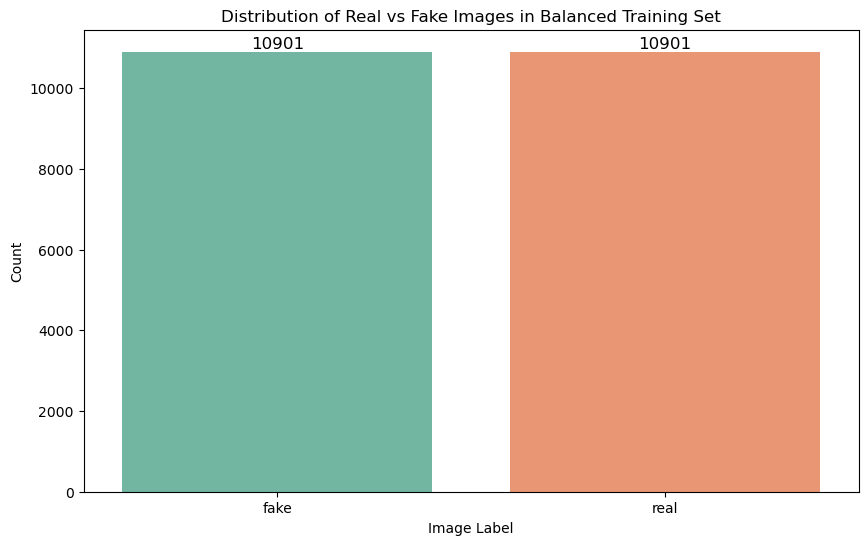

In [4]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='status', palette='Set2')  # assigned to ax for adding counts in the plot
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), #getting top coordinates
                ha='center', va='bottom', fontsize=12)
plt.title('Distribution of Real vs Fake Images in Balanced Training Set')
plt.xlabel('Image Label')
plt.ylabel('Count')
plt.show()

C:\Users\komal\AppData\Local\Temp\ipykernel_25544\2743237480.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=val_df, x='status', palette='Set1')  # assign to 'ax' so we can annotate


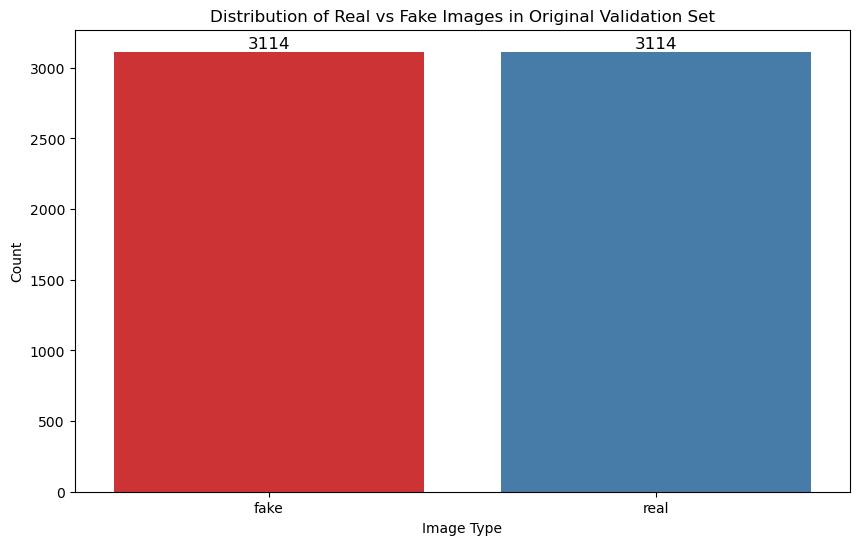

In [5]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=val_df, x='status', palette='Set1')  # assign to 'ax' so we can annotate

# Add counts on top of each bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12)
plt.title('Distribution of Real vs Fake Images in Original Validation Set')
plt.xlabel('Image Type')
plt.ylabel('Count')
plt.show()

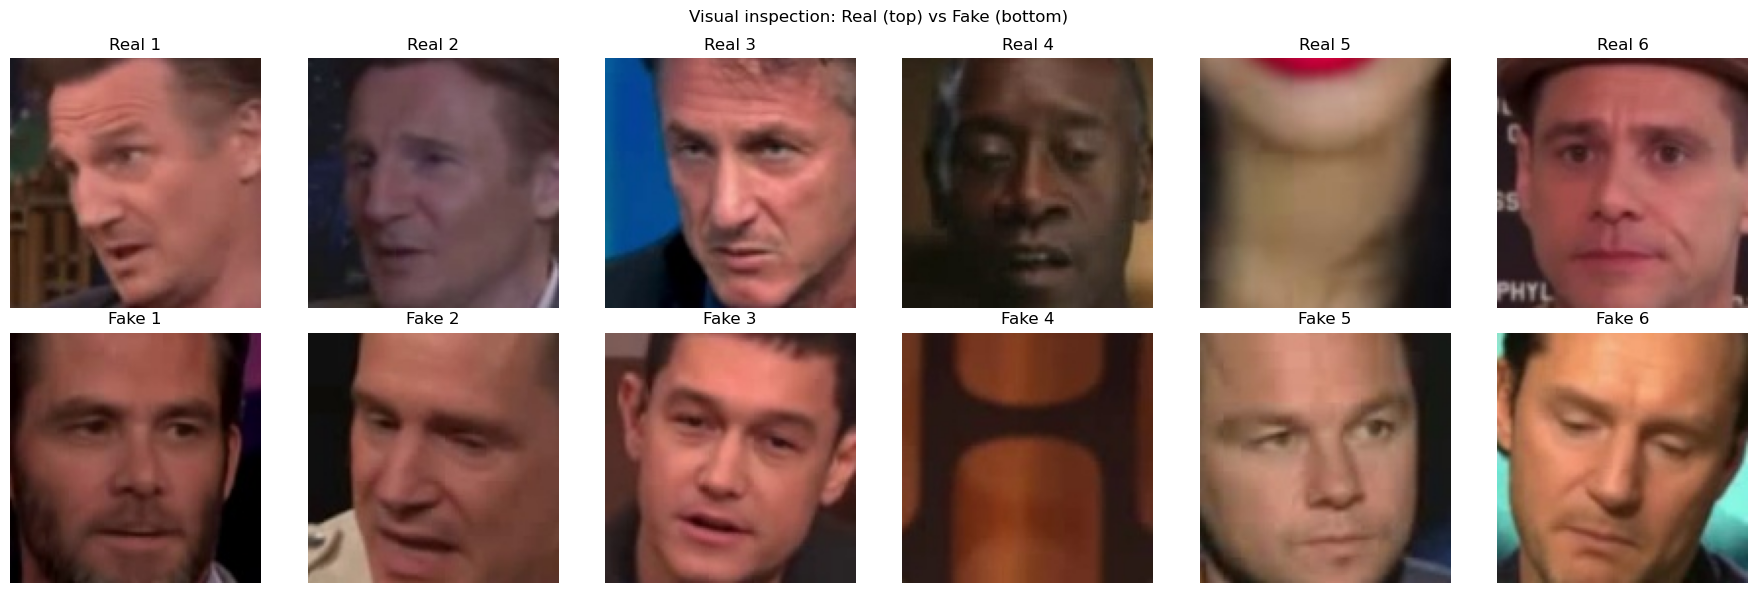

In [6]:
# Visual inspection
from PIL import Image
real_series = df[df['status']=='real']['image_path']
fake_series = df[df['status']=='fake']['image_path']
vi_real_paths = real_series.sample(6).tolist()
vi_fake_paths = fake_series.sample(6).tolist()
fig, axes = plt.subplots(2, 6, figsize=(18, 6))
for i, p in enumerate(vi_real_paths):
    axes[0, i].imshow(Image.open(p).convert('RGB'))
    axes[0, i].set_title(f'Real {i+1}')
    axes[0, i].axis('off')
for i, p in enumerate(vi_fake_paths):
    axes[1, i].imshow(Image.open(p).convert('RGB'))
    axes[1, i].set_title(f'Fake {i+1}')
    axes[1, i].axis('off')
plt.suptitle('Visual inspection: Real (top) vs Fake (bottom)', y=0.98)
plt.tight_layout()
plt.show()

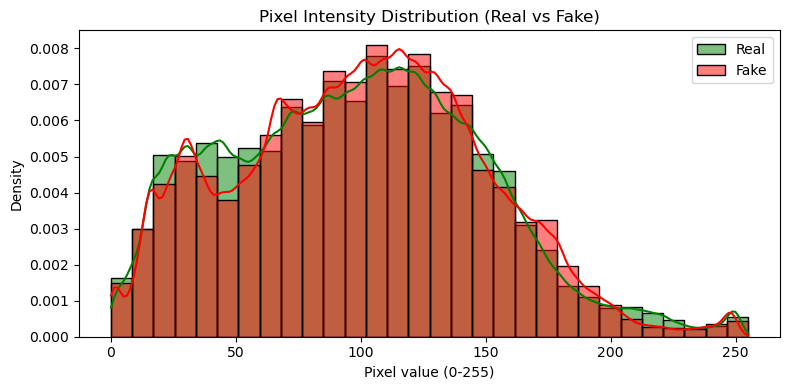

In [7]:
import numpy as np
from PIL import Image

# Choosing a small sample for speed
n_per_class = 200
real_paths = df[df['status'] == 'real']['image_path'].sample(n=min(n_per_class, (df['status'] == 'real').sum()), random_state=42)
fake_paths = df[df['status'] == 'fake']['image_path'].sample(n=min(n_per_class, (df['status'] == 'fake').sum()), random_state=42)

real_imgs = np.array([np.array(Image.open(p).convert('L')) for p in real_paths])
fake_imgs = np.array([np.array(Image.open(p).convert('L')) for p in fake_paths])

plt.figure(figsize=(8, 4))
sns.histplot(real_imgs.flatten(), color='green', label='Real', kde=True, stat='density', bins=30)
sns.histplot(fake_imgs.flatten(), color='red', label='Fake', kde=True, stat='density', bins=30)
plt.legend()
plt.title("Pixel Intensity Distribution (Real vs Fake)")
plt.xlabel("Pixel value (0-255)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

### Step 4: Create a Custom PyTorch Dataset with Augmentation

In [8]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class ImageClassificationDataset(Dataset):
    def __init__(self, dataframe, image_processor, augmentation_transforms=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_processor = image_processor
        self.augmentation_transforms = augmentation_transforms
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Get the image path and label
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']
        image = Image.open(img_path).convert('RGB')
        if self.augmentation_transforms:
            image = self.augmentation_transforms(image)
        
        # Process the image using HuggingFace processor
        # This handles resizing, normalization, and conversion to tensor
        encoding = self.image_processor(images=image, return_tensors="pt")
        #since we are processing one image at a time, remove the additional batch dimension
        pixel_values = encoding['pixel_values'].squeeze(0) # (batch_size, channels, height, width) -> (channels, height, width)

        return {
            'pixel_values': pixel_values,
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Define augmentation transforms for training data
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomRotation(10),
])

# Load the image processor for handling preprocessing specific to SwinV2
from transformers import AutoImageProcessor

model_name = "microsoft/swinv2-small-patch4-window8-256"
image_processor = AutoImageProcessor.from_pretrained(model_name)

# Create datasets with augmentation for training and without for validation
train_dataset = ImageClassificationDataset(
    df, 
    image_processor,
    augmentation_transforms=train_transforms
)

val_dataset = ImageClassificationDataset(
    val_df, 
    image_processor,
    augmentation_transforms=None  # No augmentation for validation
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 21802
Validation dataset size: 6228


### Step 5: Configure the Model and Training Arguments

In [ ]:
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer, AutoModelForImageClassification

MODEL_CHECKPOINT = "microsoft/swinv2-small-patch4-window8-256"
#configure the model for binary classification
model = AutoModelForImageClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=2,
    ignore_mismatched_sizes=True
)
#since our dataset is balance we can directly use accuracy
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./swinv2-real-vs-fake",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=25,
    fp16=True,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    remove_unused_columns=False,
)

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-small-patch4-window8-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Step 6: Start Training

In [ ]:
from transformers import EarlyStoppingCallback
#Since our GPU resources are limited, we add early stopping to prevent overfitting and save time.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor, 
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("Starting training...")
trainer.train()
print("Training finished!")

C:\Users\komal\AppData\Local\Temp\ipykernel_50984\3965322472.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Starting training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.206500,0.120750,0.962781
2,0.157900,0.103924,0.967532
3,0.086400,0.107735,0.972601
4,0.041800,0.070358,0.981945
5,0.083400,0.070273,0.981311
6,0.068900,0.071337,0.981470


✅ Training finished!
